In [1]:
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [2]:
data_1 = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines=True)
data_2 = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
data =  pd.concat([data_1, data_2])
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF" 
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF" 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [4]:
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    head_lines = list()
    lines = df["headline"].values.tolist()

    for line in lines:
        line = clean_text(line)
        tokens = word_tokenize(line)
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

head_lines = CleanTokenize(data)

In [5]:
import numpy as np

max_length = 25
validation_split = 0.2
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['is_sarcastic'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  28657
vocab size - 28658


In [6]:
embeddings_index = {}
embedding_dim = 100
f = open('../input/glovetwitter27b100dtxt/glove.twitter.27B.100d.txt', encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [7]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

24755


In [8]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [35]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 100)           2865800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,983,177
Trainable params: 117,377
Non-trainable params: 2,865,800
_________________________________________________________________
None


In [36]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/25
1384/1384 - 61s - loss: 0.5055 - acc: 0.7558 - val_loss: 0.4468 - val_acc: 0.7927
Epoch 2/25
1384/1384 - 60s - loss: 0.4210 - acc: 0.8080 - val_loss: 0.3716 - val_acc: 0.8315
Epoch 3/25
1384/1384 - 59s - loss: 0.3715 - acc: 0.8345 - val_loss: 0.3437 - val_acc: 0.8480
Epoch 4/25
1384/1384 - 61s - loss: 0.3372 - acc: 0.8524 - val_loss: 0.3310 - val_acc: 0.8566
Epoch 5/25
1384/1384 - 58s - loss: 0.3023 - acc: 0.8689 - val_loss: 0.3078 - val_acc: 0.8689
Epoch 6/25
1384/1384 - 61s - loss: 0.2736 - acc: 0.8839 - val_loss: 0.2946 - val_acc: 0.8776
Epoch 7/25
1384/1384 - 59s - loss: 0.2490 - acc: 0.8957 - val_loss: 0.2603 - val_acc: 0.8947
Epoch 8/25
1384/1384 - 58s - loss: 0.2279 - acc: 0.9065 - val_loss: 0.2612 - val_acc: 0.9016
Epoch 9/25
1384/1384 - 65s - loss: 0.2108 - acc: 0.9146 - val_loss: 0.2391 - val_acc: 0.9063
Epoch 10/25
1384/1384 - 59s - loss: 0.1904 - acc: 0.9239 - val_loss: 0.2276 - val_acc: 0.9145
Epoch 11/25
1384/1384 - 59s - loss: 0.1798 - acc: 0.9290 - val_loss: 

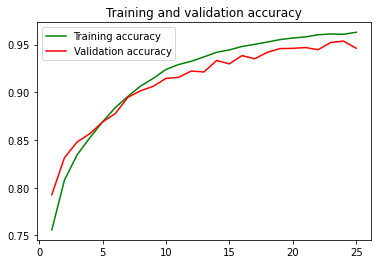

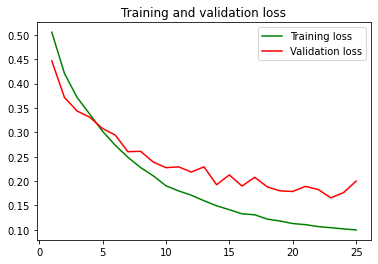

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!" 
    else: return "It's not a sarcasm."


In [34]:
predict_sarcasm("i had a good day. i lost 10000 rupees")

"It's a sarcasm!"